## **Import Libraries**

In [25]:
import sys
import os
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

plt.style.use('ggplot')

In [26]:
current_dir = os.getcwd()
project_root = os.path.abspath(os.path.join(current_dir, '..'))
if project_root not in sys.path:
    sys.path.append(project_root)

In [27]:
from src.model import EffcientNetDF
from src.utils import set_seed, train_one_epoch, evaluate, save_checkpoint, save_experiment_json

In [28]:
import os
from torchvision import datasets
from torch.utils.data import DataLoader
from src.preprocessing import get_transforms

## **Helper Functions**

In [29]:
def flip_label(y):
    return 1 - y

def get_dataloaders(root_dir, model_name, batch_size=32):
    """
    Args:
        root_dir: Should point to 'data/images' containing 'train' and 'val' folders.
    """
    # Define path
    train_dir = os.path.join(root_dir, 'train')
    valid_dir = os.path.join(root_dir, 'val')
    
    # Transforms
    transform = get_transforms(model_name)
    
    # Create Dataset with ImageFolder
    train_dataset = datasets.ImageFolder(root=train_dir, transform=transform, target_transform=flip_label)
    valid_dataset = datasets.ImageFolder(root=valid_dir, transform=transform, target_transform=flip_label)
    
    print(f"Classes found: {train_dataset.class_to_idx}")
    print("APPLYING LABEL FLIP: Mapped 'fake'-> 1 and 'real'-> 0 internally.")
    
    # Loaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        pin_memory=True)
    valid_loader = DataLoader(
        valid_dataset,
        batch_size=batch_size,
        shuffle=False,
        pin_memory=True)
    
    return train_loader, valid_loader

In [30]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [31]:
def plot_confusion_matrix_heatmap(y_true, y_pred, class_names=['Real', 'Fake']):
    """
    Generates and plots a confusion matrix heatmap.
    """
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, 
                yticklabels=class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    img_save = f"../results/{MODEL_NAME}_{TASK_NAME}_cfm.png"
    plt.savefig(img_save)
    plt.show()

## **Setup & Configurations**

In [32]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
set_seed(42)

print(f"Project Root: {project_root}")
print(f"Device: {DEVICE}")

Project Root: d:\VNUK ASSIGNMENTS\3rd YEAR\1st SEM\AI\deepfake-detection\deep_fake_detection
Device: cuda


In [33]:
DATA_ROOT = '../data/images'
RESULTS_DIR = '../results'
os.makedirs(RESULTS_DIR, exist_ok=True)

MODEL_NAME = 'efficientnet'
TASK_NAME = 'deepfake_detection'

In [34]:
BATCH_SIZE = 32

# Train Head Only
EPOCHS_STAGE_1 = 15
LR_STAGE_1 = 0.001

# Fine-Tune
EPOCHS_STAGE_2 = 15
LR_STAGE_2 = 0.0001

In [35]:
history = {
    "model_name": MODEL_NAME,
    "train_losses": [],
    "val_losses": [],
    "train_accuracy": [],
    "val_accuracy": [],
    "val_f1": [],
    "val_auc": [],
    "EPOCHS": EPOCHS_STAGE_1 + EPOCHS_STAGE_2,
    "best_accuracy": 0.0,
    "best_epoch": 0,
    "MODEL_SAVED_PATH": ""
}

## **Loading Data**

In [36]:
train_loader, valid_loader = get_dataloaders(DATA_ROOT, MODEL_NAME, BATCH_SIZE)

print(f"- Train batches: {len(train_loader)}")
print(f"- Valid batches: {len(valid_loader)}")

Classes found: {'fake': 0, 'real': 1}
APPLYING LABEL FLIP: Mapped 'fake'-> 1 and 'real'-> 0 internally.
- Train batches: 750
- Valid batches: 125


## **Stage 1 - Training Head Only**

### **Initialize Model & Optimizer**

In [38]:
model = EffcientNetDF(num_classes=2, pretrained=True).to(DEVICE)

In [37]:
print(model)

EffcientNetDF(
  (model): EfficientNet(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): MBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
              (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
            (1): SqueezeExcitation(
              (avgpool): AdaptiveAvgPool2d(output_size=1)
              (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (activation): SiLU(inplace=True)
              (scale_a

In [39]:
# Freeze Backbone
for param in model.model.features.parameters():
    param.requires_grad = False
    
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Trainable Prarmeters (Stage 1):", trainable_params)

Trainable Prarmeters (Stage 1): 2562


In [40]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR_STAGE_1)

### **Training**

In [41]:
best_acc = 0.0

In [42]:
for epoch in range(EPOCHS_STAGE_1):
    train_acc, train_loss = train_one_epoch(model, train_loader, criterion, optimizer, DEVICE)
    valid_loss, valid_acc, valid_f1, valid_auc = evaluate(model, valid_loader, criterion, DEVICE)
    
    history["train_losses"].append(train_loss)
    history["train_accuracy"].append(train_acc)
    history["val_losses"].append(valid_loss)
    history["val_accuracy"].append(valid_acc)
    history["val_f1"].append(valid_f1)
    history["val_auc"].append(valid_auc)
    
    print(f"[{epoch + 1}/{EPOCHS_STAGE_1}] train_acc: {train_acc:.4f} - train_loss: {train_loss:.4f} - valid_acc: {valid_acc:.4f} - valid_loss: {valid_loss:.4f}")
    
    if valid_acc > best_acc:
        best_acc = valid_acc
        save_name = f"../results/best_{MODEL_NAME}.pth"
        save_checkpoint(model, optimizer, save_name)
        
        # Update best stats
        history["best_accuracy"] = best_acc
        history["best_epoch"] = epoch + 1
        history["MODEL_SAVED_PATH"] = save_name
        
    print(f"\t- [current best] epoch: {history['best_epoch']} - acc: {history['best_accuracy']:.4f}\n")

Evaluating: 100%|██████████| 125/125 [00:29<00:00,  4.28it/s]


[1/15] train_acc: 0.6226 - train_loss: 0.6476 - valid_acc: 0.6365 - valid_loss: 0.6407
Checkpoint saved: ../results/best_efficientnet.pth
	- [current best] epoch: 1 - acc: 0.6365



Evaluating: 100%|██████████| 125/125 [00:28<00:00,  4.31it/s]


[2/15] train_acc: 0.6485 - train_loss: 0.6254 - valid_acc: 0.6595 - valid_loss: 0.6158
Checkpoint saved: ../results/best_efficientnet.pth
	- [current best] epoch: 2 - acc: 0.6595



Evaluating: 100%|██████████| 125/125 [01:01<00:00,  2.02it/s]


[3/15] train_acc: 0.6482 - train_loss: 0.6261 - valid_acc: 0.6623 - valid_loss: 0.6164
Checkpoint saved: ../results/best_efficientnet.pth
	- [current best] epoch: 3 - acc: 0.6623



Evaluating: 100%|██████████| 125/125 [00:55<00:00,  2.26it/s]


[4/15] train_acc: 0.6484 - train_loss: 0.6261 - valid_acc: 0.6665 - valid_loss: 0.6113
Checkpoint saved: ../results/best_efficientnet.pth
	- [current best] epoch: 4 - acc: 0.6665



Evaluating: 100%|██████████| 125/125 [00:34<00:00,  3.67it/s]


[5/15] train_acc: 0.6526 - train_loss: 0.6249 - valid_acc: 0.6695 - valid_loss: 0.6057
Checkpoint saved: ../results/best_efficientnet.pth
	- [current best] epoch: 5 - acc: 0.6695



Evaluating: 100%|██████████| 125/125 [00:47<00:00,  2.62it/s]


[6/15] train_acc: 0.6525 - train_loss: 0.6275 - valid_acc: 0.6647 - valid_loss: 0.6109
	- [current best] epoch: 5 - acc: 0.6695



Evaluating: 100%|██████████| 125/125 [00:51<00:00,  2.43it/s]


[7/15] train_acc: 0.6473 - train_loss: 0.6308 - valid_acc: 0.6645 - valid_loss: 0.6131
	- [current best] epoch: 5 - acc: 0.6695



Evaluating: 100%|██████████| 125/125 [00:50<00:00,  2.48it/s]


[8/15] train_acc: 0.6521 - train_loss: 0.6261 - valid_acc: 0.6653 - valid_loss: 0.6094
	- [current best] epoch: 5 - acc: 0.6695



Evaluating: 100%|██████████| 125/125 [00:51<00:00,  2.41it/s]


[9/15] train_acc: 0.6534 - train_loss: 0.6243 - valid_acc: 0.6617 - valid_loss: 0.6197
	- [current best] epoch: 5 - acc: 0.6695



Evaluating: 100%|██████████| 125/125 [00:51<00:00,  2.45it/s]


[10/15] train_acc: 0.6512 - train_loss: 0.6252 - valid_acc: 0.6550 - valid_loss: 0.6237
	- [current best] epoch: 5 - acc: 0.6695



Evaluating: 100%|██████████| 125/125 [00:44<00:00,  2.79it/s]


[11/15] train_acc: 0.6509 - train_loss: 0.6246 - valid_acc: 0.6737 - valid_loss: 0.6068
Checkpoint saved: ../results/best_efficientnet.pth
	- [current best] epoch: 11 - acc: 0.6737



Evaluating: 100%|██████████| 125/125 [00:44<00:00,  2.78it/s]


[12/15] train_acc: 0.6532 - train_loss: 0.6257 - valid_acc: 0.6635 - valid_loss: 0.6202
	- [current best] epoch: 11 - acc: 0.6737



Evaluating: 100%|██████████| 125/125 [00:30<00:00,  4.16it/s]


[13/15] train_acc: 0.6536 - train_loss: 0.6237 - valid_acc: 0.6733 - valid_loss: 0.6104
	- [current best] epoch: 11 - acc: 0.6737



Evaluating: 100%|██████████| 125/125 [00:29<00:00,  4.25it/s]


[14/15] train_acc: 0.6543 - train_loss: 0.6241 - valid_acc: 0.6767 - valid_loss: 0.6088
Checkpoint saved: ../results/best_efficientnet.pth
	- [current best] epoch: 14 - acc: 0.6767



Evaluating: 100%|██████████| 125/125 [00:28<00:00,  4.35it/s]

[15/15] train_acc: 0.6488 - train_loss: 0.6278 - valid_acc: 0.6650 - valid_loss: 0.6082
	- [current best] epoch: 14 - acc: 0.6767



## **Stage 2. Fine-Tuning**

In [43]:
# Unfreeze for Fine-Tuning
for param in model.parameters():
    param.requires_grad = True

In [44]:
optimizer = optim.Adam(model.parameters(), lr=LR_STAGE_2)
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Trainable Parameters (Stage 2): {trainable_params}")

Trainable Parameters (Stage 2): 4010110


In [45]:
TOTAL_EPOCHS = EPOCHS_STAGE_1 + EPOCHS_STAGE_2
for epoch in range(EPOCHS_STAGE_1, TOTAL_EPOCHS):
    train_acc, train_loss = train_one_epoch(model, train_loader, criterion, optimizer, DEVICE)
    valid_loss, valid_acc, valid_f1, valid_auc = evaluate(model, valid_loader, criterion, DEVICE)
    
    history["train_losses"].append(train_loss)
    history["train_accuracy"].append(train_acc)
    history["val_losses"].append(valid_loss)
    history["val_accuracy"].append(valid_acc)
    history["val_f1"].append(valid_f1)
    history["val_auc"].append(valid_auc)
    
    print(f"[{epoch + 1}/{TOTAL_EPOCHS} (Fine-Tune)] train_acc: {train_acc:.4f} - train_loss: {train_loss:.4f} - valid_acc: {valid_acc:.4f} - valid_loss: {valid_loss:.4f}")
    
    if valid_acc > best_acc:
        best_acc = valid_acc
        save_name = f"../results/best_{MODEL_NAME}_finetuned.pth"
        save_checkpoint(model, optimizer, save_name) 
        
        # Update best stats
        history["best_accuracy"] = best_acc
        history["best_epoch"] = epoch + 1
        history["MODEL_SAVED_PATH"] = save_name
        
    print(f"\t- [current best] epoch: {history['best_epoch']} - acc: {history['best_accuracy']:.4f}\n")

Evaluating: 100%|██████████| 125/125 [00:28<00:00,  4.37it/s]


[16/30 (Fine-Tune)] train_acc: 0.8107 - train_loss: 0.4029 - valid_acc: 0.8740 - valid_loss: 0.3081
Checkpoint saved: ../results/best_efficientnet_finetuned.pth
	- [current best] epoch: 16 - acc: 0.8740



Evaluating: 100%|██████████| 125/125 [00:29<00:00,  4.26it/s]


[17/30 (Fine-Tune)] train_acc: 0.9203 - train_loss: 0.1972 - valid_acc: 0.9020 - valid_loss: 0.2620
Checkpoint saved: ../results/best_efficientnet_finetuned.pth
	- [current best] epoch: 17 - acc: 0.9020



Evaluating: 100%|██████████| 125/125 [00:27<00:00,  4.48it/s]


[18/30 (Fine-Tune)] train_acc: 0.9507 - train_loss: 0.1271 - valid_acc: 0.9093 - valid_loss: 0.2452
Checkpoint saved: ../results/best_efficientnet_finetuned.pth
	- [current best] epoch: 18 - acc: 0.9093



Evaluating: 100%|██████████| 125/125 [00:29<00:00,  4.28it/s]


[19/30 (Fine-Tune)] train_acc: 0.9628 - train_loss: 0.0949 - valid_acc: 0.9165 - valid_loss: 0.2726
Checkpoint saved: ../results/best_efficientnet_finetuned.pth
	- [current best] epoch: 19 - acc: 0.9165



Evaluating: 100%|██████████| 125/125 [00:32<00:00,  3.80it/s]


[20/30 (Fine-Tune)] train_acc: 0.9712 - train_loss: 0.0770 - valid_acc: 0.9193 - valid_loss: 0.2946
Checkpoint saved: ../results/best_efficientnet_finetuned.pth
	- [current best] epoch: 20 - acc: 0.9193



Evaluating: 100%|██████████| 125/125 [00:36<00:00,  3.41it/s]


[21/30 (Fine-Tune)] train_acc: 0.9762 - train_loss: 0.0625 - valid_acc: 0.9190 - valid_loss: 0.2937
	- [current best] epoch: 20 - acc: 0.9193



Evaluating: 100%|██████████| 125/125 [00:39<00:00,  3.19it/s]


[22/30 (Fine-Tune)] train_acc: 0.9814 - train_loss: 0.0494 - valid_acc: 0.9120 - valid_loss: 0.3512
	- [current best] epoch: 20 - acc: 0.9193



Evaluating: 100%|██████████| 125/125 [00:44<00:00,  2.79it/s]


[23/30 (Fine-Tune)] train_acc: 0.9843 - train_loss: 0.0431 - valid_acc: 0.9062 - valid_loss: 0.3834
	- [current best] epoch: 20 - acc: 0.9193



Evaluating: 100%|██████████| 125/125 [00:38<00:00,  3.21it/s]


[24/30 (Fine-Tune)] train_acc: 0.9851 - train_loss: 0.0408 - valid_acc: 0.9187 - valid_loss: 0.3839
	- [current best] epoch: 20 - acc: 0.9193



Evaluating: 100%|██████████| 125/125 [00:28<00:00,  4.33it/s]


[25/30 (Fine-Tune)] train_acc: 0.9869 - train_loss: 0.0359 - valid_acc: 0.9327 - valid_loss: 0.3361
Checkpoint saved: ../results/best_efficientnet_finetuned.pth
	- [current best] epoch: 25 - acc: 0.9327



Evaluating: 100%|██████████| 125/125 [00:29<00:00,  4.19it/s]


[26/30 (Fine-Tune)] train_acc: 0.9876 - train_loss: 0.0335 - valid_acc: 0.9300 - valid_loss: 0.3981
	- [current best] epoch: 25 - acc: 0.9327



Evaluating: 100%|██████████| 125/125 [00:28<00:00,  4.34it/s]


[27/30 (Fine-Tune)] train_acc: 0.9907 - train_loss: 0.0276 - valid_acc: 0.9213 - valid_loss: 0.3478
	- [current best] epoch: 25 - acc: 0.9327



Evaluating: 100%|██████████| 125/125 [01:45<00:00,  1.18it/s]


[28/30 (Fine-Tune)] train_acc: 0.9900 - train_loss: 0.0276 - valid_acc: 0.9260 - valid_loss: 0.3713
	- [current best] epoch: 25 - acc: 0.9327



Evaluating: 100%|██████████| 125/125 [00:32<00:00,  3.82it/s]


[29/30 (Fine-Tune)] train_acc: 0.9904 - train_loss: 0.0270 - valid_acc: 0.9243 - valid_loss: 0.3927
	- [current best] epoch: 25 - acc: 0.9327



Evaluating: 100%|██████████| 125/125 [00:32<00:00,  3.82it/s]

[30/30 (Fine-Tune)] train_acc: 0.9928 - train_loss: 0.0206 - valid_acc: 0.9235 - valid_loss: 0.3876
	- [current best] epoch: 25 - acc: 0.9327



In [46]:
json_path = f"{RESULTS_DIR}/{MODEL_NAME}_{TASK_NAME}_history.json"
save_experiment_json(history, json_path)

History saved to ../results/efficientnet_deepfake_detection_history.json


## **Performance Evaluation**

<Figure size 1200x600 with 0 Axes>

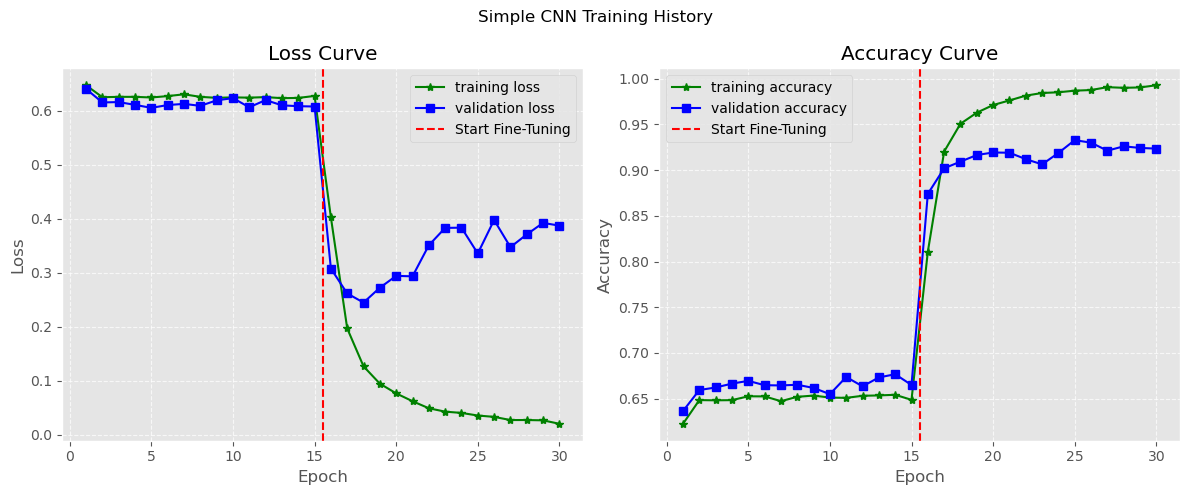

In [54]:
plt.style.use('ggplot')
plt.figure(figsize=(12, 6))

epochs = range(1, len(history["train_losses"]) + 1)

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

plt.suptitle("Simple CNN Training History")

ax[0].plot(epochs, history["train_losses"], label='training loss', marker='*', color='green')
ax[0].plot(epochs, history["val_losses"], label='validation loss', marker='s', color='blue')
ax[0].set_title("Loss Curve")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Loss")
ax[0].grid(True, linestyle='--', alpha=0.7)
ax[0].axvline(x=EPOCHS_STAGE_1 + 0.5, color='red', linestyle='--', label='Start Fine-Tuning')
ax[0].legend()

ax[1].plot(epochs, history["train_accuracy"], label='training accuracy', marker='*', color='green')
ax[1].plot(epochs, history["val_accuracy"], label='validation accuracy', marker='s', color='blue')
ax[1].set_title("Accuracy Curve")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Accuracy")
ax[1].grid(True, linestyle='--', alpha=0.7)
ax[1].axvline(x=EPOCHS_STAGE_1 + 0.5, color='red', linestyle='--', label='Start Fine-Tuning')
ax[1].legend()

img_save = f"../results/{MODEL_NAME}_{TASK_NAME}.png"
plt.savefig(img_save)
plt.tight_layout()
plt.show()

In [48]:
from tqdm import tqdm

model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for images, labels in tqdm(valid_loader, desc="Getting Predictions"):
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)
        
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        
        y_pred.extend(preds.cpu().numpy())
        y_true.extend(labels.cpu().numpy())

Getting Predictions: 100%|██████████| 125/125 [00:27<00:00,  4.52it/s]


In [51]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_true, y_pred)
print(f"EfficientNet Accuracy: {accuracy:.4f}")

EfficientNet Accuracy: 0.9235


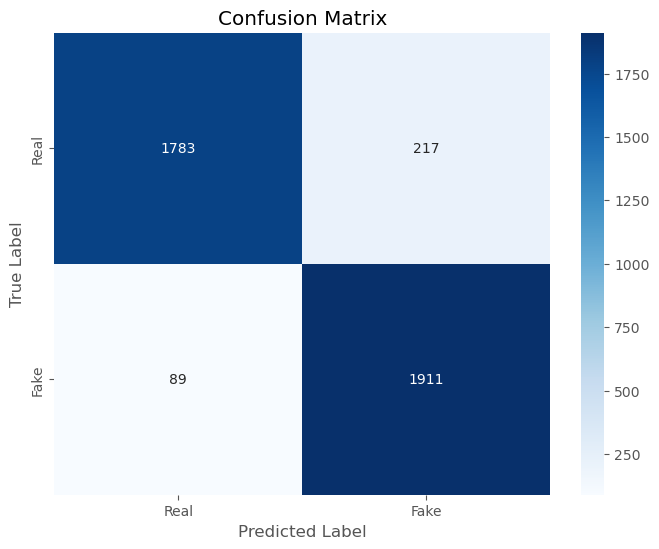

In [52]:
plot_confusion_matrix_heatmap(y_true, y_pred, class_names=['Real', 'Fake'])